# Fish Muscle Stress Relaxation

Fit relaxation of fish muscle data with generalized and fractional Maxwell models.

**Data:** examples/data/pyRheo/fish_muscle/stressrelaxation_fishmuscle_data.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.models.herschel_bulkley import HerschelBulkley
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


INFO:2025-12-06 21:30:30,214:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load relaxation data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'fish_muscle'
df = pd.read_csv(DATA_DIR / 'stressrelaxation_fishmuscle_data.csv', sep='	')
df.columns = df.columns.str.strip()

# Columns: Time (s), Relaxation Modulus (Pa)
t = df.iloc[:,0].to_numpy()
sigma = df.iloc[:,1].to_numpy()

data = RheoData(x=t, y=sigma, x_units='s', y_units='Pa', domain='relaxation')
print(df.head())


     Time  Relaxation Modulus
0  0.0139             33600.0
1  0.0149             33243.0
2  0.0159             31100.0
3  0.0169             30900.0
4  0.0180             31700.0


## Fit relaxation models

In [4]:
gm = GeneralizedMaxwell(n_modes=5, modulus_type='tensile')
gm.fit(t, sigma, test_mode='relaxation', use_log_residuals=True, use_multi_start=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, sigma)

fm = FractionalMaxwellModel()
fm.fit(t, sigma, test_mode='relaxation', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='relaxation')
fm_r2 = r2_complex(sigma, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.707171s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=4.971501e+06 | time=0.707s | final_gradient_norm=35796038930.74231


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.215309s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=4.971501e+06 | time=0.215s | final_gradient_norm=35796038930.74231


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.560062s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=17 | final_cost=1.182519e+07 | time=0.560s | final_gradient_norm=91805897761.52263


Element minimization: early termination at n_modes=4 (R²=0.999285 < threshold=0.999549)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 1.215078s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=6.142524e+03 | time=1.215s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


{'gm_r2': 0.9996992915644162, 'fm_r2': -311.71653162797617}


## Plot relaxation fits

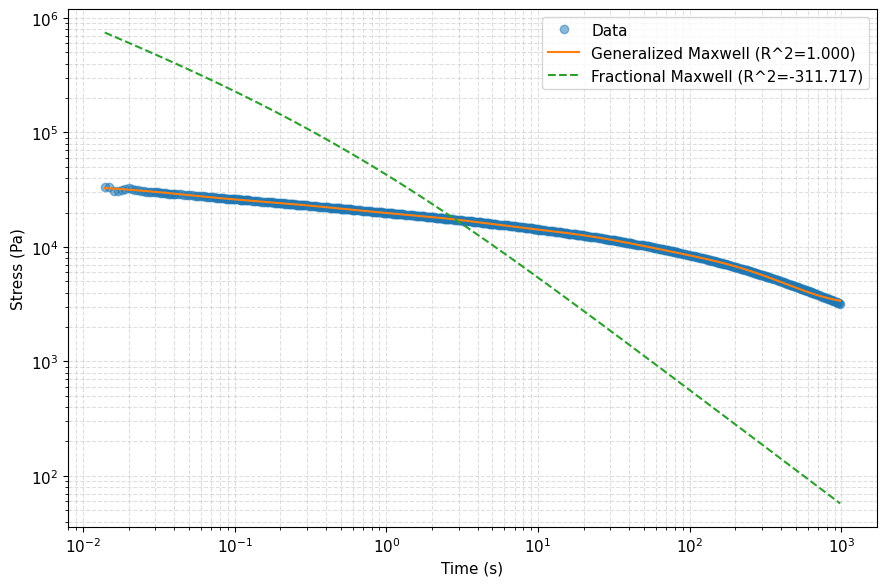

In [5]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(t, sigma, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'Generalized Maxwell (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional Maxwell (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Stress (Pa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.220099s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=4.971501e+06 | time=0.220s | final_gradient_norm=35796038930.74231


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.300269s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=4.971501e+06 | time=0.300s | final_gradient_norm=35796038930.74231


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.205061s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=17 | final_cost=1.182519e+07 | time=0.205s | final_gradient_norm=91805897761.52263


Element minimization: early termination at n_modes=4 (R²=0.999285 < threshold=0.999549)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 0.629886s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=6.142524e+03 | time=0.630s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


Model ranking (R²): [('gm', 1.0), ('fm', -311.717)]


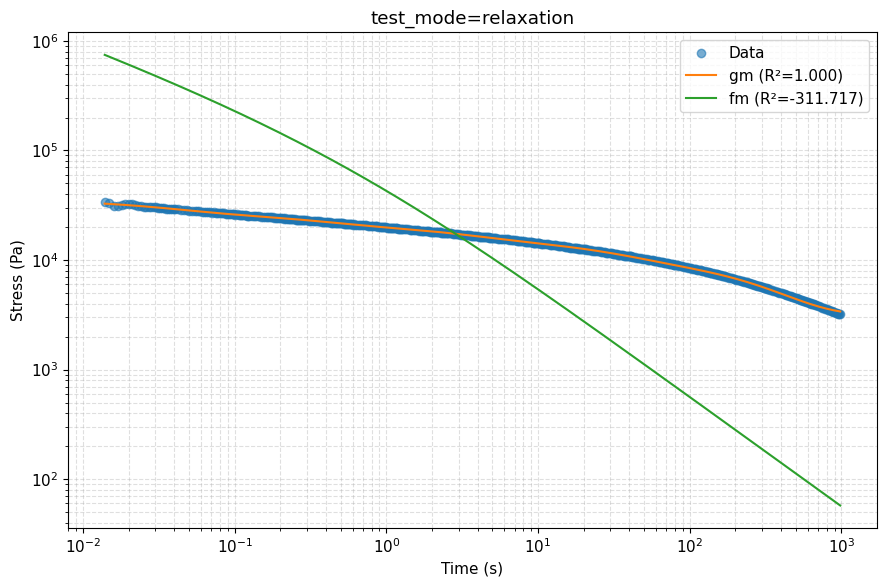

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<55:31,  1.20it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 35/4000 [00:00<01:18, 50.29it/s, 511 steps of size 7.03e-04. acc. prob=0.70]

warmup:   2%|▏         | 61/4000 [00:01<00:45, 86.22it/s, 63 steps of size 7.43e-04. acc. prob=0.73] 

warmup:   2%|▏         | 91/4000 [00:01<00:30, 126.69it/s, 511 steps of size 5.78e-04. acc. prob=0.74]

warmup:   3%|▎         | 117/4000 [00:01<00:25, 153.74it/s, 511 steps of size 2.11e-02. acc. prob=0.76]

warmup:   4%|▎         | 145/4000 [00:01<00:21, 182.71it/s, 127 steps of size 3.05e-02. acc. prob=0.77]

warmup:   4%|▍         | 173/4000 [00:01<00:18, 206.73it/s, 191 steps of size 6.73e-02. acc. prob=0.77]

warmup:   5%|▌         | 211/4000 [00:01<00:15, 251.27it/s, 511 steps of size 2.26e-02. acc. prob=0.77]

warmup:   6%|▌         | 249/4000 [00:01<00:13, 282.84it/s, 255 steps of size 4.18e-02. acc. prob=0.78]

warmup:   7%|▋         | 281/4000 [00:01<00:13, 284.37it/s, 127 steps of size 2.43e-02. acc. prob=0.78]

warmup:   8%|▊         | 314/4000 [00:01<00:12, 294.85it/s, 255 steps of size 4.20e-02. acc. prob=0.78]

warmup:   9%|▉         | 354/4000 [00:01<00:11, 324.33it/s, 127 steps of size 6.93e-02. acc. prob=0.78]

warmup:  10%|█         | 402/4000 [00:02<00:09, 367.19it/s, 127 steps of size 5.64e-02. acc. prob=0.78]

warmup:  11%|█▏        | 455/4000 [00:02<00:08, 414.17it/s, 31 steps of size 2.97e-02. acc. prob=0.78] 

warmup:  12%|█▏        | 498/4000 [00:02<00:09, 388.12it/s, 63 steps of size 6.23e-02. acc. prob=0.78]

warmup:  13%|█▎        | 538/4000 [00:02<00:09, 378.78it/s, 255 steps of size 2.64e-02. acc. prob=0.78]

warmup:  15%|█▍        | 582/4000 [00:02<00:08, 393.97it/s, 127 steps of size 4.20e-02. acc. prob=0.78]

warmup:  16%|█▌        | 628/4000 [00:02<00:08, 410.09it/s, 127 steps of size 2.79e-02. acc. prob=0.79]

warmup:  17%|█▋        | 680/4000 [00:02<00:07, 439.18it/s, 127 steps of size 3.78e-02. acc. prob=0.79]

warmup:  18%|█▊        | 731/4000 [00:02<00:07, 457.20it/s, 63 steps of size 7.85e-02. acc. prob=0.79] 

warmup:  20%|█▉        | 784/4000 [00:02<00:06, 476.99it/s, 63 steps of size 4.72e-02. acc. prob=0.79]

warmup:  21%|██        | 832/4000 [00:03<00:06, 471.91it/s, 127 steps of size 6.42e-02. acc. prob=0.79]

warmup:  22%|██▏       | 886/4000 [00:03<00:06, 490.71it/s, 63 steps of size 5.92e-02. acc. prob=0.79] 

warmup:  24%|██▎       | 942/4000 [00:03<00:06, 508.81it/s, 127 steps of size 6.16e-02. acc. prob=0.79]

warmup:  25%|██▍       | 994/4000 [00:03<00:06, 449.74it/s, 127 steps of size 3.77e-02. acc. prob=0.79]

sample:  26%|██▌       | 1041/4000 [00:03<00:07, 420.13it/s, 15 steps of size 3.45e-02. acc. prob=0.95]

sample:  27%|██▋       | 1085/4000 [00:03<00:07, 414.60it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  28%|██▊       | 1128/4000 [00:03<00:07, 402.00it/s, 95 steps of size 3.45e-02. acc. prob=0.95] 

sample:  29%|██▉       | 1169/4000 [00:03<00:07, 393.29it/s, 127 steps of size 3.45e-02. acc. prob=0.94]

sample:  30%|███       | 1209/4000 [00:03<00:07, 386.21it/s, 127 steps of size 3.45e-02. acc. prob=0.94]

sample:  31%|███       | 1248/4000 [00:04<00:07, 383.07it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  32%|███▏      | 1287/4000 [00:04<00:07, 373.62it/s, 63 steps of size 3.45e-02. acc. prob=0.95] 

sample:  33%|███▎      | 1327/4000 [00:04<00:07, 377.54it/s, 191 steps of size 3.45e-02. acc. prob=0.95]

sample:  34%|███▍      | 1365/4000 [00:04<00:07, 360.45it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  35%|███▌      | 1402/4000 [00:04<00:07, 351.13it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  36%|███▌      | 1438/4000 [00:04<00:07, 349.87it/s, 15 steps of size 3.45e-02. acc. prob=0.95] 

sample:  37%|███▋      | 1474/4000 [00:04<00:07, 341.23it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  38%|███▊      | 1512/4000 [00:04<00:07, 350.59it/s, 63 steps of size 3.45e-02. acc. prob=0.95] 

sample:  39%|███▉      | 1550/4000 [00:04<00:06, 358.34it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  40%|███▉      | 1586/4000 [00:05<00:06, 354.19it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  41%|████      | 1622/4000 [00:05<00:06, 345.85it/s, 63 steps of size 3.45e-02. acc. prob=0.95] 

sample:  41%|████▏     | 1657/4000 [00:05<00:06, 342.54it/s, 255 steps of size 3.45e-02. acc. prob=0.95]

sample:  42%|████▏     | 1692/4000 [00:05<00:06, 339.71it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  43%|████▎     | 1730/4000 [00:05<00:06, 350.80it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  44%|████▍     | 1768/4000 [00:05<00:06, 354.57it/s, 255 steps of size 3.45e-02. acc. prob=0.95]

sample:  45%|████▌     | 1806/4000 [00:05<00:06, 361.82it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  46%|████▌     | 1843/4000 [00:05<00:05, 361.35it/s, 63 steps of size 3.45e-02. acc. prob=0.94] 

sample:  47%|████▋     | 1881/4000 [00:05<00:05, 364.56it/s, 127 steps of size 3.45e-02. acc. prob=0.94]

sample:  48%|████▊     | 1918/4000 [00:05<00:05, 357.59it/s, 127 steps of size 3.45e-02. acc. prob=0.94]

sample:  49%|████▉     | 1954/4000 [00:06<00:05, 354.21it/s, 127 steps of size 3.45e-02. acc. prob=0.94]

sample:  50%|████▉     | 1992/4000 [00:06<00:05, 359.10it/s, 127 steps of size 3.45e-02. acc. prob=0.94]

sample:  51%|█████     | 2030/4000 [00:06<00:05, 362.93it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2067/4000 [00:06<00:05, 361.88it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2104/4000 [00:06<00:05, 363.33it/s, 95 steps of size 3.45e-02. acc. prob=0.95] 

sample:  54%|█████▎    | 2141/4000 [00:06<00:05, 354.66it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  54%|█████▍    | 2177/4000 [00:06<00:05, 348.55it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  55%|█████▌    | 2212/4000 [00:06<00:05, 347.21it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  56%|█████▋    | 2250/4000 [00:06<00:04, 353.90it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2287/4000 [00:06<00:04, 357.46it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2323/4000 [00:07<00:04, 354.76it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  59%|█████▉    | 2359/4000 [00:07<00:04, 354.80it/s, 63 steps of size 3.45e-02. acc. prob=0.95] 

sample:  60%|█████▉    | 2397/4000 [00:07<00:04, 360.36it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  61%|██████    | 2435/4000 [00:07<00:04, 365.94it/s, 15 steps of size 3.45e-02. acc. prob=0.95] 

sample:  62%|██████▏   | 2472/4000 [00:07<00:04, 366.55it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2509/4000 [00:07<00:04, 359.09it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2550/4000 [00:07<00:03, 371.93it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  65%|██████▍   | 2588/4000 [00:07<00:03, 374.30it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2626/4000 [00:07<00:03, 361.09it/s, 255 steps of size 3.45e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2663/4000 [00:08<00:03, 356.70it/s, 63 steps of size 3.45e-02. acc. prob=0.95] 

sample:  68%|██████▊   | 2701/4000 [00:08<00:03, 362.19it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2738/4000 [00:08<00:03, 361.31it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  69%|██████▉   | 2775/4000 [00:08<00:03, 355.24it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  70%|███████   | 2811/4000 [00:08<00:03, 352.45it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  71%|███████   | 2847/4000 [00:08<00:03, 351.93it/s, 31 steps of size 3.45e-02. acc. prob=0.95] 

sample:  72%|███████▏  | 2886/4000 [00:08<00:03, 360.18it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  73%|███████▎  | 2923/4000 [00:08<00:03, 355.95it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  74%|███████▍  | 2959/4000 [00:08<00:03, 340.84it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  75%|███████▍  | 2997/4000 [00:08<00:02, 349.24it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  76%|███████▌  | 3033/4000 [00:09<00:02, 342.25it/s, 95 steps of size 3.45e-02. acc. prob=0.95] 

sample:  77%|███████▋  | 3068/4000 [00:09<00:02, 342.56it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3103/4000 [00:09<00:02, 340.71it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3140/4000 [00:09<00:02, 348.36it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  79%|███████▉  | 3176/4000 [00:09<00:02, 350.75it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  80%|████████  | 3216/4000 [00:09<00:02, 360.92it/s, 255 steps of size 3.45e-02. acc. prob=0.95]

sample:  81%|████████▏ | 3253/4000 [00:09<00:02, 360.58it/s, 63 steps of size 3.45e-02. acc. prob=0.95] 

sample:  82%|████████▏ | 3290/4000 [00:09<00:01, 362.53it/s, 63 steps of size 3.45e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3328/4000 [00:09<00:01, 364.90it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  84%|████████▍ | 3365/4000 [00:10<00:01, 362.21it/s, 191 steps of size 3.45e-02. acc. prob=0.95]

sample:  85%|████████▌ | 3402/4000 [00:10<00:01, 352.42it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  86%|████████▌ | 3438/4000 [00:10<00:01, 345.13it/s, 63 steps of size 3.45e-02. acc. prob=0.95] 

sample:  87%|████████▋ | 3473/4000 [00:10<00:01, 345.33it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3512/4000 [00:10<00:01, 356.91it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  89%|████████▊ | 3549/4000 [00:10<00:01, 360.58it/s, 255 steps of size 3.45e-02. acc. prob=0.95]

sample:  90%|████████▉ | 3587/4000 [00:10<00:01, 364.68it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  91%|█████████ | 3624/4000 [00:10<00:01, 364.70it/s, 63 steps of size 3.45e-02. acc. prob=0.95] 

sample:  92%|█████████▏| 3661/4000 [00:10<00:00, 361.69it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3698/4000 [00:10<00:00, 349.38it/s, 63 steps of size 3.45e-02. acc. prob=0.95] 

sample:  93%|█████████▎| 3734/4000 [00:11<00:00, 345.33it/s, 255 steps of size 3.45e-02. acc. prob=0.95]

sample:  94%|█████████▍| 3769/4000 [00:11<00:00, 344.94it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  95%|█████████▌| 3804/4000 [00:11<00:00, 337.46it/s, 255 steps of size 3.45e-02. acc. prob=0.95]

sample:  96%|█████████▌| 3841/4000 [00:11<00:00, 345.89it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3880/4000 [00:11<00:00, 356.03it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3916/4000 [00:11<00:00, 350.98it/s, 63 steps of size 3.45e-02. acc. prob=0.95] 

sample:  99%|█████████▉| 3952/4000 [00:11<00:00, 350.14it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample: 100%|█████████▉| 3988/4000 [00:11<00:00, 341.67it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:11<00:00, 337.76it/s, 127 steps of size 3.45e-02. acc. prob=0.95]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 37/4000 [00:00<00:11, 358.75it/s, 1023 steps of size 4.36e-04. acc. prob=0.70]

warmup:   2%|▏         | 73/4000 [00:00<00:15, 252.51it/s, 63 steps of size 1.03e-03. acc. prob=0.74]  

warmup:   3%|▎         | 101/4000 [00:00<00:17, 228.73it/s, 1023 steps of size 9.41e-03. acc. prob=0.75]

warmup:   3%|▎         | 125/4000 [00:00<00:17, 227.28it/s, 63 steps of size 1.80e-02. acc. prob=0.76]  

warmup:   4%|▍         | 155/4000 [00:00<00:15, 248.08it/s, 255 steps of size 2.75e-02. acc. prob=0.76]

warmup:   5%|▍         | 185/4000 [00:00<00:14, 262.08it/s, 255 steps of size 4.69e-02. acc. prob=0.77]

warmup:   5%|▌         | 218/4000 [00:00<00:13, 280.39it/s, 255 steps of size 1.25e-02. acc. prob=0.77]

warmup:   6%|▋         | 256/4000 [00:00<00:12, 308.27it/s, 127 steps of size 5.17e-02. acc. prob=0.77]

warmup:   7%|▋         | 289/4000 [00:01<00:11, 314.46it/s, 63 steps of size 5.30e-02. acc. prob=0.78] 

warmup:   8%|▊         | 333/4000 [00:01<00:10, 351.63it/s, 127 steps of size 9.53e-02. acc. prob=0.78]

warmup:   9%|▉         | 375/4000 [00:01<00:09, 370.23it/s, 127 steps of size 4.02e-02. acc. prob=0.78]

warmup:  10%|█         | 416/4000 [00:01<00:09, 379.09it/s, 127 steps of size 4.69e-02. acc. prob=0.78]

warmup:  12%|█▏        | 463/4000 [00:01<00:08, 405.04it/s, 255 steps of size 4.53e-02. acc. prob=0.78]

warmup:  13%|█▎        | 504/4000 [00:01<00:09, 357.01it/s, 511 steps of size 2.00e-02. acc. prob=0.78]

warmup:  14%|█▎        | 543/4000 [00:01<00:09, 364.25it/s, 127 steps of size 6.03e-02. acc. prob=0.78]

warmup:  15%|█▍        | 590/4000 [00:01<00:08, 390.81it/s, 127 steps of size 4.06e-02. acc. prob=0.78]

warmup:  16%|█▌        | 636/4000 [00:01<00:08, 409.07it/s, 63 steps of size 5.27e-02. acc. prob=0.79] 

warmup:  17%|█▋        | 682/4000 [00:01<00:07, 423.17it/s, 63 steps of size 6.16e-02. acc. prob=0.79]

warmup:  18%|█▊        | 733/4000 [00:02<00:07, 448.24it/s, 127 steps of size 4.77e-02. acc. prob=0.79]

warmup:  20%|█▉        | 788/4000 [00:02<00:06, 477.12it/s, 63 steps of size 4.82e-02. acc. prob=0.79] 

warmup:  21%|██        | 838/4000 [00:02<00:06, 482.17it/s, 63 steps of size 5.28e-02. acc. prob=0.79]

warmup:  22%|██▏       | 889/4000 [00:02<00:06, 489.42it/s, 127 steps of size 6.01e-02. acc. prob=0.79]

warmup:  23%|██▎       | 939/4000 [00:02<00:06, 491.23it/s, 127 steps of size 4.52e-02. acc. prob=0.79]

warmup:  25%|██▍       | 989/4000 [00:02<00:06, 448.36it/s, 13 steps of size 3.60e-02. acc. prob=0.79] 

sample:  26%|██▌       | 1035/4000 [00:02<00:07, 423.17it/s, 159 steps of size 3.55e-02. acc. prob=0.95]

sample:  27%|██▋       | 1079/4000 [00:02<00:07, 404.43it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  28%|██▊       | 1121/4000 [00:02<00:07, 382.28it/s, 255 steps of size 3.55e-02. acc. prob=0.94]

sample:  29%|██▉       | 1160/4000 [00:03<00:07, 371.72it/s, 127 steps of size 3.55e-02. acc. prob=0.94]

sample:  30%|██▉       | 1198/4000 [00:03<00:07, 364.86it/s, 191 steps of size 3.55e-02. acc. prob=0.95]

sample:  31%|███       | 1235/4000 [00:03<00:07, 353.38it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  32%|███▏      | 1272/4000 [00:03<00:07, 355.79it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  33%|███▎      | 1310/4000 [00:03<00:07, 362.31it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  34%|███▎      | 1347/4000 [00:03<00:07, 362.41it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  35%|███▍      | 1384/4000 [00:03<00:07, 361.49it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  36%|███▌      | 1421/4000 [00:03<00:07, 353.28it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  36%|███▋      | 1457/4000 [00:03<00:07, 349.69it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  37%|███▋      | 1493/4000 [00:04<00:07, 335.98it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  38%|███▊      | 1528/4000 [00:04<00:07, 337.76it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  39%|███▉      | 1562/4000 [00:04<00:07, 338.21it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  40%|███▉      | 1596/4000 [00:04<00:07, 337.99it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  41%|████      | 1630/4000 [00:04<00:07, 335.99it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  42%|████▏     | 1665/4000 [00:04<00:06, 337.90it/s, 255 steps of size 3.55e-02. acc. prob=0.95]

sample:  42%|████▏     | 1699/4000 [00:04<00:06, 335.64it/s, 63 steps of size 3.55e-02. acc. prob=0.95] 

sample:  43%|████▎     | 1733/4000 [00:04<00:06, 332.41it/s, 255 steps of size 3.55e-02. acc. prob=0.95]

sample:  44%|████▍     | 1771/4000 [00:04<00:06, 345.38it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  45%|████▌     | 1809/4000 [00:04<00:06, 355.52it/s, 111 steps of size 3.55e-02. acc. prob=0.95]

sample:  46%|████▌     | 1845/4000 [00:05<00:06, 354.41it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  47%|████▋     | 1881/4000 [00:05<00:05, 355.88it/s, 191 steps of size 3.55e-02. acc. prob=0.95]

sample:  48%|████▊     | 1919/4000 [00:05<00:05, 361.76it/s, 63 steps of size 3.55e-02. acc. prob=0.95] 

sample:  49%|████▉     | 1956/4000 [00:05<00:05, 349.68it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  50%|████▉     | 1992/4000 [00:05<00:05, 349.53it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  51%|█████     | 2028/4000 [00:05<00:05, 338.31it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2065/4000 [00:05<00:05, 345.21it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  52%|█████▎    | 2100/4000 [00:05<00:05, 342.35it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2137/4000 [00:05<00:05, 347.90it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  54%|█████▍    | 2175/4000 [00:06<00:05, 356.52it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  55%|█████▌    | 2211/4000 [00:06<00:05, 346.06it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  56%|█████▌    | 2246/4000 [00:06<00:05, 339.90it/s, 15 steps of size 3.55e-02. acc. prob=0.95] 

sample:  57%|█████▋    | 2282/4000 [00:06<00:05, 343.49it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2317/4000 [00:06<00:04, 339.84it/s, 63 steps of size 3.55e-02. acc. prob=0.95] 

sample:  59%|█████▉    | 2353/4000 [00:06<00:04, 345.21it/s, 63 steps of size 3.55e-02. acc. prob=0.95]

sample:  60%|█████▉    | 2389/4000 [00:06<00:04, 346.69it/s, 175 steps of size 3.55e-02. acc. prob=0.95]

sample:  61%|██████    | 2426/4000 [00:06<00:04, 353.51it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  62%|██████▏   | 2462/4000 [00:06<00:04, 353.99it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  62%|██████▎   | 2500/4000 [00:06<00:04, 358.51it/s, 191 steps of size 3.55e-02. acc. prob=0.95]

sample:  63%|██████▎   | 2536/4000 [00:07<00:04, 356.88it/s, 143 steps of size 3.55e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2572/4000 [00:07<00:04, 352.65it/s, 63 steps of size 3.55e-02. acc. prob=0.95] 

sample:  65%|██████▌   | 2608/4000 [00:07<00:03, 350.16it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2649/4000 [00:07<00:03, 366.22it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2686/4000 [00:07<00:03, 359.13it/s, 191 steps of size 3.55e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2723/4000 [00:07<00:03, 357.69it/s, 255 steps of size 3.55e-02. acc. prob=0.95]

sample:  69%|██████▉   | 2759/4000 [00:07<00:03, 356.27it/s, 255 steps of size 3.55e-02. acc. prob=0.95]

sample:  70%|██████▉   | 2799/4000 [00:07<00:03, 367.62it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  71%|███████   | 2836/4000 [00:07<00:03, 360.95it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2873/4000 [00:08<00:03, 352.80it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  73%|███████▎  | 2909/4000 [00:08<00:03, 352.25it/s, 63 steps of size 3.55e-02. acc. prob=0.95] 

sample:  74%|███████▎  | 2947/4000 [00:08<00:02, 359.10it/s, 63 steps of size 3.55e-02. acc. prob=0.95]

sample:  75%|███████▍  | 2983/4000 [00:08<00:02, 354.09it/s, 95 steps of size 3.55e-02. acc. prob=0.95]

sample:  75%|███████▌  | 3019/4000 [00:08<00:02, 346.15it/s, 63 steps of size 3.55e-02. acc. prob=0.95]

sample:  76%|███████▋  | 3055/4000 [00:08<00:02, 348.90it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  77%|███████▋  | 3092/4000 [00:08<00:02, 353.42it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3129/4000 [00:08<00:02, 355.49it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  79%|███████▉  | 3165/4000 [00:08<00:02, 348.99it/s, 255 steps of size 3.55e-02. acc. prob=0.95]

sample:  80%|████████  | 3200/4000 [00:08<00:02, 341.48it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  81%|████████  | 3239/4000 [00:09<00:02, 353.22it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3275/4000 [00:09<00:02, 354.91it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3311/4000 [00:09<00:01, 354.56it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  84%|████████▎ | 3347/4000 [00:09<00:01, 346.64it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  85%|████████▍ | 3382/4000 [00:09<00:01, 346.37it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  85%|████████▌ | 3417/4000 [00:09<00:01, 346.63it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  86%|████████▋ | 3452/4000 [00:09<00:01, 346.27it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3487/4000 [00:09<00:01, 336.69it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3521/4000 [00:09<00:01, 333.96it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  89%|████████▉ | 3558/4000 [00:09<00:01, 344.30it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  90%|████████▉ | 3593/4000 [00:10<00:01, 340.93it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  91%|█████████ | 3631/4000 [00:10<00:01, 349.23it/s, 255 steps of size 3.55e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3666/4000 [00:10<00:00, 343.96it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3701/4000 [00:10<00:00, 326.22it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3737/4000 [00:10<00:00, 333.70it/s, 255 steps of size 3.55e-02. acc. prob=0.95]

sample:  94%|█████████▍| 3771/4000 [00:10<00:00, 332.82it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  95%|█████████▌| 3805/4000 [00:10<00:00, 331.08it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample:  96%|█████████▌| 3839/4000 [00:10<00:00, 331.88it/s, 63 steps of size 3.55e-02. acc. prob=0.95] 

sample:  97%|█████████▋| 3876/4000 [00:10<00:00, 342.25it/s, 79 steps of size 3.55e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3911/4000 [00:11<00:00, 337.10it/s, 79 steps of size 3.55e-02. acc. prob=0.95]

sample:  99%|█████████▊| 3946/4000 [00:11<00:00, 339.08it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

sample: 100%|█████████▉| 3980/4000 [00:11<00:00, 335.33it/s, 63 steps of size 3.55e-02. acc. prob=0.95] 

sample: 100%|██████████| 4000/4000 [00:11<00:00, 353.96it/s, 127 steps of size 3.55e-02. acc. prob=0.95]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 33/4000 [00:00<00:12, 325.85it/s, 255 steps of size 8.45e-04. acc. prob=0.69]

warmup:   2%|▏         | 66/4000 [00:00<00:19, 206.22it/s, 319 steps of size 5.67e-04. acc. prob=0.73]

warmup:   2%|▏         | 93/4000 [00:00<00:17, 226.45it/s, 255 steps of size 8.17e-04. acc. prob=0.75]

warmup:   3%|▎         | 118/4000 [00:00<00:17, 227.55it/s, 7 steps of size 2.61e-02. acc. prob=0.76] 

warmup:   4%|▍         | 155/4000 [00:00<00:14, 271.97it/s, 191 steps of size 3.57e-02. acc. prob=0.77]

warmup:   5%|▍         | 184/4000 [00:00<00:14, 269.36it/s, 127 steps of size 4.51e-02. acc. prob=0.77]

warmup:   6%|▌         | 221/4000 [00:00<00:12, 297.90it/s, 255 steps of size 2.35e-02. acc. prob=0.77]

warmup:   6%|▋         | 256/4000 [00:00<00:11, 313.33it/s, 255 steps of size 4.06e-02. acc. prob=0.77]

warmup:   7%|▋         | 295/4000 [00:01<00:11, 335.86it/s, 255 steps of size 4.82e-02. acc. prob=0.78]

warmup:   8%|▊         | 331/4000 [00:01<00:10, 342.24it/s, 127 steps of size 4.68e-02. acc. prob=0.78]

warmup:   9%|▉         | 372/4000 [00:01<00:10, 360.79it/s, 127 steps of size 5.96e-02. acc. prob=0.78]

warmup:  10%|█         | 418/4000 [00:01<00:09, 389.52it/s, 255 steps of size 3.77e-02. acc. prob=0.78]

warmup:  11%|█▏        | 458/4000 [00:01<00:09, 381.54it/s, 511 steps of size 1.92e-02. acc. prob=0.78]

warmup:  12%|█▏        | 497/4000 [00:01<00:10, 349.46it/s, 3 steps of size 1.18e-02. acc. prob=0.78]  

warmup:  13%|█▎        | 533/4000 [00:01<00:10, 343.30it/s, 127 steps of size 3.18e-02. acc. prob=0.78]

warmup:  14%|█▍        | 576/4000 [00:01<00:09, 366.86it/s, 31 steps of size 2.98e-02. acc. prob=0.78] 

warmup:  15%|█▌        | 617/4000 [00:01<00:08, 377.95it/s, 127 steps of size 4.14e-02. acc. prob=0.79]

warmup:  17%|█▋        | 661/4000 [00:01<00:08, 394.79it/s, 127 steps of size 4.87e-02. acc. prob=0.79]

warmup:  18%|█▊        | 706/4000 [00:02<00:08, 410.73it/s, 63 steps of size 5.02e-02. acc. prob=0.79] 

warmup:  19%|█▉        | 756/4000 [00:02<00:07, 435.51it/s, 63 steps of size 3.77e-02. acc. prob=0.79]

warmup:  20%|██        | 800/4000 [00:02<00:07, 435.14it/s, 127 steps of size 4.23e-02. acc. prob=0.79]

warmup:  21%|██        | 849/4000 [00:02<00:07, 448.26it/s, 127 steps of size 4.85e-02. acc. prob=0.79]

warmup:  22%|██▏       | 897/4000 [00:02<00:06, 453.81it/s, 127 steps of size 4.90e-02. acc. prob=0.79]

warmup:  24%|██▎       | 944/4000 [00:02<00:06, 456.32it/s, 63 steps of size 6.44e-02. acc. prob=0.79] 

warmup:  25%|██▍       | 990/4000 [00:02<00:07, 418.07it/s, 127 steps of size 4.10e-02. acc. prob=0.79]

sample:  26%|██▌       | 1033/4000 [00:02<00:07, 403.74it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  27%|██▋       | 1074/4000 [00:02<00:07, 391.45it/s, 63 steps of size 3.87e-02. acc. prob=0.92] 

sample:  28%|██▊       | 1114/4000 [00:03<00:07, 387.50it/s, 255 steps of size 3.87e-02. acc. prob=0.93]

sample:  29%|██▉       | 1153/4000 [00:03<00:07, 387.02it/s, 127 steps of size 3.87e-02. acc. prob=0.92]

sample:  30%|██▉       | 1192/4000 [00:03<00:07, 381.77it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  31%|███       | 1231/4000 [00:03<00:07, 372.89it/s, 31 steps of size 3.87e-02. acc. prob=0.93] 

sample:  32%|███▏      | 1273/4000 [00:03<00:07, 383.37it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  33%|███▎      | 1313/4000 [00:03<00:06, 386.07it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  34%|███▍      | 1352/4000 [00:03<00:06, 379.75it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  35%|███▍      | 1391/4000 [00:03<00:06, 376.17it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  36%|███▌      | 1429/4000 [00:03<00:06, 371.06it/s, 255 steps of size 3.87e-02. acc. prob=0.93]

sample:  37%|███▋      | 1468/4000 [00:04<00:06, 376.13it/s, 63 steps of size 3.87e-02. acc. prob=0.93] 

sample:  38%|███▊      | 1507/4000 [00:04<00:06, 379.19it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  39%|███▊      | 1547/4000 [00:04<00:06, 383.57it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  40%|███▉      | 1586/4000 [00:04<00:06, 369.36it/s, 255 steps of size 3.87e-02. acc. prob=0.93]

sample:  41%|████      | 1627/4000 [00:04<00:06, 378.63it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  42%|████▏     | 1665/4000 [00:04<00:06, 362.18it/s, 255 steps of size 3.87e-02. acc. prob=0.93]

sample:  43%|████▎     | 1702/4000 [00:04<00:06, 360.03it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  44%|████▎     | 1740/4000 [00:04<00:06, 363.73it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  45%|████▍     | 1782/4000 [00:04<00:05, 377.80it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  46%|████▌     | 1820/4000 [00:04<00:05, 377.88it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  46%|████▋     | 1858/4000 [00:05<00:05, 373.68it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  47%|████▋     | 1896/4000 [00:05<00:05, 368.14it/s, 255 steps of size 3.87e-02. acc. prob=0.93]

sample:  48%|████▊     | 1936/4000 [00:05<00:05, 374.78it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  49%|████▉     | 1974/4000 [00:05<00:05, 373.43it/s, 63 steps of size 3.87e-02. acc. prob=0.93] 

sample:  50%|█████     | 2012/4000 [00:05<00:05, 369.88it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  51%|█████▏    | 2050/4000 [00:05<00:05, 365.84it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  52%|█████▏    | 2087/4000 [00:05<00:05, 364.70it/s, 103 steps of size 3.87e-02. acc. prob=0.93]

sample:  53%|█████▎    | 2125/4000 [00:05<00:05, 368.83it/s, 127 steps of size 3.87e-02. acc. prob=0.93]

sample:  54%|█████▍    | 2166/4000 [00:05<00:04, 378.34it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  55%|█████▌    | 2204/4000 [00:05<00:04, 365.44it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  56%|█████▌    | 2242/4000 [00:06<00:04, 369.53it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2280/4000 [00:06<00:04, 371.36it/s, 111 steps of size 3.87e-02. acc. prob=0.94]

sample:  58%|█████▊    | 2319/4000 [00:06<00:04, 376.65it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2357/4000 [00:06<00:04, 366.33it/s, 87 steps of size 3.87e-02. acc. prob=0.94] 

sample:  60%|█████▉    | 2395/4000 [00:06<00:04, 369.74it/s, 255 steps of size 3.87e-02. acc. prob=0.94]

sample:  61%|██████    | 2434/4000 [00:06<00:04, 375.64it/s, 63 steps of size 3.87e-02. acc. prob=0.94] 

sample:  62%|██████▏   | 2472/4000 [00:06<00:04, 376.59it/s, 63 steps of size 3.87e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2510/4000 [00:06<00:03, 375.11it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  64%|██████▎   | 2548/4000 [00:06<00:03, 370.17it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  65%|██████▍   | 2586/4000 [00:07<00:03, 368.01it/s, 63 steps of size 3.87e-02. acc. prob=0.94] 

sample:  66%|██████▌   | 2623/4000 [00:07<00:03, 357.66it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2665/4000 [00:07<00:03, 374.37it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2703/4000 [00:07<00:03, 374.56it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  69%|██████▊   | 2741/4000 [00:07<00:03, 370.11it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  70%|██████▉   | 2781/4000 [00:07<00:03, 376.58it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  70%|███████   | 2819/4000 [00:07<00:03, 351.47it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  71%|███████▏  | 2857/4000 [00:07<00:03, 357.76it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  72%|███████▏  | 2894/4000 [00:07<00:03, 359.82it/s, 63 steps of size 3.87e-02. acc. prob=0.94] 

sample:  73%|███████▎  | 2931/4000 [00:07<00:02, 357.02it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2968/4000 [00:08<00:02, 358.50it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  75%|███████▌  | 3006/4000 [00:08<00:02, 363.58it/s, 63 steps of size 3.87e-02. acc. prob=0.94] 

sample:  76%|███████▌  | 3043/4000 [00:08<00:02, 363.47it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3085/4000 [00:08<00:02, 378.99it/s, 63 steps of size 3.87e-02. acc. prob=0.94] 

sample:  78%|███████▊  | 3125/4000 [00:08<00:02, 384.41it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  79%|███████▉  | 3164/4000 [00:08<00:02, 385.23it/s, 255 steps of size 3.87e-02. acc. prob=0.94]

sample:  80%|████████  | 3204/4000 [00:08<00:02, 387.80it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  81%|████████  | 3245/4000 [00:08<00:01, 393.42it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3285/4000 [00:08<00:01, 384.84it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  83%|████████▎ | 3324/4000 [00:08<00:01, 380.50it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3363/4000 [00:09<00:01, 380.39it/s, 63 steps of size 3.87e-02. acc. prob=0.94] 

sample:  85%|████████▌ | 3402/4000 [00:09<00:01, 373.04it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3442/4000 [00:09<00:01, 379.51it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3481/4000 [00:09<00:01, 377.60it/s, 15 steps of size 3.87e-02. acc. prob=0.94] 

sample:  88%|████████▊ | 3520/4000 [00:09<00:01, 379.61it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3558/4000 [00:09<00:01, 367.11it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  90%|████████▉ | 3597/4000 [00:09<00:01, 371.00it/s, 159 steps of size 3.87e-02. acc. prob=0.94]

sample:  91%|█████████ | 3638/4000 [00:09<00:00, 379.74it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  92%|█████████▏| 3677/4000 [00:09<00:00, 382.72it/s, 51 steps of size 3.87e-02. acc. prob=0.94] 

sample:  93%|█████████▎| 3716/4000 [00:10<00:00, 381.06it/s, 191 steps of size 3.87e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3757/4000 [00:10<00:00, 388.38it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  95%|█████████▍| 3796/4000 [00:10<00:00, 385.70it/s, 63 steps of size 3.87e-02. acc. prob=0.94] 

sample:  96%|█████████▌| 3835/4000 [00:10<00:00, 374.50it/s, 127 steps of size 3.87e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3874/4000 [00:10<00:00, 376.76it/s, 191 steps of size 3.87e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3912/4000 [00:10<00:00, 371.93it/s, 255 steps of size 3.87e-02. acc. prob=0.94]

sample:  99%|█████████▉| 3950/4000 [00:10<00:00, 360.95it/s, 255 steps of size 3.87e-02. acc. prob=0.94]

sample: 100%|█████████▉| 3987/4000 [00:10<00:00, 363.03it/s, 63 steps of size 3.87e-02. acc. prob=0.94] 

sample: 100%|██████████| 4000/4000 [00:10<00:00, 370.24it/s, 63 steps of size 3.87e-02. acc. prob=0.94]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 39/4000 [00:00<00:10, 370.50it/s, 511 steps of size 3.26e-04. acc. prob=0.70]

warmup:   2%|▏         | 77/4000 [00:00<00:15, 253.42it/s, 511 steps of size 6.26e-04. acc. prob=0.74]

warmup:   3%|▎         | 105/4000 [00:00<00:16, 233.22it/s, 31 steps of size 6.52e-03. acc. prob=0.75]

warmup:   3%|▎         | 130/4000 [00:00<00:16, 230.71it/s, 63 steps of size 9.60e-03. acc. prob=0.76]

warmup:   4%|▍         | 162/4000 [00:00<00:14, 256.66it/s, 255 steps of size 6.36e-02. acc. prob=0.77]

warmup:   5%|▍         | 189/4000 [00:00<00:15, 252.52it/s, 42 steps of size 2.17e-02. acc. prob=0.77] 

warmup:   5%|▌         | 216/4000 [00:00<00:14, 254.72it/s, 255 steps of size 2.46e-02. acc. prob=0.77]

warmup:   6%|▋         | 254/4000 [00:00<00:12, 291.24it/s, 511 steps of size 1.46e-02. acc. prob=0.77]

warmup:   7%|▋         | 284/4000 [00:01<00:12, 287.87it/s, 63 steps of size 1.12e-01. acc. prob=0.78] 

warmup:   8%|▊         | 318/4000 [00:01<00:12, 302.25it/s, 255 steps of size 5.47e-02. acc. prob=0.78]

warmup:   9%|▉         | 360/4000 [00:01<00:10, 336.23it/s, 31 steps of size 3.43e-02. acc. prob=0.78] 

warmup:  10%|█         | 408/4000 [00:01<00:09, 376.96it/s, 111 steps of size 4.34e-02. acc. prob=0.78]

warmup:  11%|█▏        | 455/4000 [00:01<00:08, 401.43it/s, 127 steps of size 2.46e-02. acc. prob=0.78]

warmup:  12%|█▏        | 496/4000 [00:01<00:09, 374.64it/s, 63 steps of size 1.02e-01. acc. prob=0.78] 

warmup:  14%|█▎        | 540/4000 [00:01<00:08, 387.89it/s, 255 steps of size 3.08e-02. acc. prob=0.78]

warmup:  15%|█▍        | 588/4000 [00:01<00:08, 410.78it/s, 127 steps of size 6.05e-02. acc. prob=0.79]

warmup:  16%|█▌        | 632/4000 [00:01<00:08, 418.60it/s, 191 steps of size 4.94e-02. acc. prob=0.79]

warmup:  17%|█▋        | 680/4000 [00:01<00:07, 435.73it/s, 63 steps of size 3.98e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 728/4000 [00:02<00:07, 446.55it/s, 127 steps of size 4.57e-02. acc. prob=0.79]

warmup:  19%|█▉        | 774/4000 [00:02<00:07, 449.93it/s, 127 steps of size 4.57e-02. acc. prob=0.79]

warmup:  21%|██        | 824/4000 [00:02<00:06, 462.26it/s, 111 steps of size 5.91e-02. acc. prob=0.79]

warmup:  22%|██▏       | 875/4000 [00:02<00:06, 475.27it/s, 63 steps of size 6.27e-02. acc. prob=0.79] 

warmup:  23%|██▎       | 928/4000 [00:02<00:06, 490.92it/s, 11 steps of size 3.89e-02. acc. prob=0.79]

warmup:  24%|██▍       | 978/4000 [00:02<00:06, 441.44it/s, 63 steps of size 1.04e-01. acc. prob=0.79]

sample:  26%|██▌       | 1024/4000 [00:02<00:07, 415.94it/s, 103 steps of size 3.74e-02. acc. prob=0.95]

sample:  27%|██▋       | 1067/4000 [00:02<00:07, 393.99it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  28%|██▊       | 1108/4000 [00:03<00:07, 388.59it/s, 127 steps of size 3.74e-02. acc. prob=0.95]

sample:  29%|██▊       | 1148/4000 [00:03<00:07, 387.80it/s, 127 steps of size 3.74e-02. acc. prob=0.95]

sample:  30%|██▉       | 1190/4000 [00:03<00:07, 395.40it/s, 127 steps of size 3.74e-02. acc. prob=0.95]

sample:  31%|███       | 1230/4000 [00:03<00:07, 380.69it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  32%|███▏      | 1272/4000 [00:03<00:06, 391.64it/s, 63 steps of size 3.74e-02. acc. prob=0.94] 

sample:  33%|███▎      | 1312/4000 [00:03<00:06, 389.50it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  34%|███▍      | 1352/4000 [00:03<00:06, 387.25it/s, 63 steps of size 3.74e-02. acc. prob=0.94] 

sample:  35%|███▍      | 1392/4000 [00:03<00:06, 389.49it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  36%|███▌      | 1432/4000 [00:03<00:06, 387.65it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  37%|███▋      | 1471/4000 [00:03<00:06, 384.69it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  38%|███▊      | 1513/4000 [00:04<00:06, 394.13it/s, 63 steps of size 3.74e-02. acc. prob=0.94] 

sample:  39%|███▉      | 1553/4000 [00:04<00:06, 386.32it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  40%|███▉      | 1592/4000 [00:04<00:06, 384.78it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  41%|████      | 1633/4000 [00:04<00:06, 390.41it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  42%|████▏     | 1673/4000 [00:04<00:06, 384.95it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  43%|████▎     | 1713/4000 [00:04<00:05, 388.96it/s, 95 steps of size 3.74e-02. acc. prob=0.94] 

sample:  44%|████▍     | 1752/4000 [00:04<00:05, 382.24it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  45%|████▍     | 1791/4000 [00:04<00:05, 372.74it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  46%|████▌     | 1829/4000 [00:04<00:05, 372.25it/s, 63 steps of size 3.74e-02. acc. prob=0.94] 

sample:  47%|████▋     | 1867/4000 [00:04<00:05, 370.40it/s, 63 steps of size 3.74e-02. acc. prob=0.94]

sample:  48%|████▊     | 1906/4000 [00:05<00:05, 374.94it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  49%|████▊     | 1944/4000 [00:05<00:05, 359.29it/s, 255 steps of size 3.74e-02. acc. prob=0.94]

sample:  50%|████▉     | 1982/4000 [00:05<00:05, 362.79it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  50%|█████     | 2019/4000 [00:05<00:05, 361.60it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  51%|█████▏    | 2056/4000 [00:05<00:05, 361.76it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2096/4000 [00:05<00:05, 372.06it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  53%|█████▎    | 2135/4000 [00:05<00:04, 374.72it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  54%|█████▍    | 2173/4000 [00:05<00:04, 370.32it/s, 255 steps of size 3.74e-02. acc. prob=0.94]

sample:  55%|█████▌    | 2214/4000 [00:05<00:04, 379.80it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  56%|█████▋    | 2253/4000 [00:06<00:04, 382.48it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  57%|█████▋    | 2292/4000 [00:06<00:04, 371.75it/s, 63 steps of size 3.74e-02. acc. prob=0.94] 

sample:  58%|█████▊    | 2332/4000 [00:06<00:04, 379.22it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  59%|█████▉    | 2371/4000 [00:06<00:04, 372.98it/s, 63 steps of size 3.74e-02. acc. prob=0.94] 

sample:  60%|██████    | 2409/4000 [00:06<00:04, 374.37it/s, 63 steps of size 3.74e-02. acc. prob=0.94]

sample:  61%|██████▏   | 2451/4000 [00:06<00:04, 384.93it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2491/4000 [00:06<00:03, 387.53it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  63%|██████▎   | 2530/4000 [00:06<00:03, 383.29it/s, 191 steps of size 3.74e-02. acc. prob=0.94]

sample:  64%|██████▍   | 2569/4000 [00:06<00:03, 375.09it/s, 31 steps of size 3.74e-02. acc. prob=0.94] 

sample:  65%|██████▌   | 2609/4000 [00:06<00:03, 380.88it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  66%|██████▌   | 2648/4000 [00:07<00:03, 376.68it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  67%|██████▋   | 2686/4000 [00:07<00:03, 371.11it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  68%|██████▊   | 2726/4000 [00:07<00:03, 376.67it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  69%|██████▉   | 2767/4000 [00:07<00:03, 385.81it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  70%|███████   | 2806/4000 [00:07<00:03, 384.87it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  71%|███████   | 2845/4000 [00:07<00:03, 381.49it/s, 63 steps of size 3.74e-02. acc. prob=0.94] 

sample:  72%|███████▏  | 2885/4000 [00:07<00:02, 386.48it/s, 63 steps of size 3.74e-02. acc. prob=0.94]

sample:  73%|███████▎  | 2924/4000 [00:07<00:02, 381.62it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  74%|███████▍  | 2963/4000 [00:07<00:02, 384.01it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  75%|███████▌  | 3002/4000 [00:08<00:02, 373.37it/s, 63 steps of size 3.74e-02. acc. prob=0.94] 

sample:  76%|███████▌  | 3040/4000 [00:08<00:02, 369.35it/s, 255 steps of size 3.74e-02. acc. prob=0.94]

sample:  77%|███████▋  | 3080/4000 [00:08<00:02, 377.50it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  78%|███████▊  | 3121/4000 [00:08<00:02, 383.99it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  79%|███████▉  | 3160/4000 [00:08<00:02, 380.30it/s, 95 steps of size 3.74e-02. acc. prob=0.94] 

sample:  80%|███████▉  | 3199/4000 [00:08<00:02, 376.53it/s, 95 steps of size 3.74e-02. acc. prob=0.94]

sample:  81%|████████  | 3239/4000 [00:08<00:01, 383.08it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  82%|████████▏ | 3278/4000 [00:08<00:01, 380.86it/s, 63 steps of size 3.74e-02. acc. prob=0.94] 

sample:  83%|████████▎ | 3317/4000 [00:08<00:01, 375.62it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  84%|████████▍ | 3355/4000 [00:08<00:01, 371.39it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  85%|████████▍ | 3393/4000 [00:09<00:01, 370.35it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  86%|████████▌ | 3434/4000 [00:09<00:01, 380.16it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  87%|████████▋ | 3473/4000 [00:09<00:01, 382.80it/s, 63 steps of size 3.74e-02. acc. prob=0.94] 

sample:  88%|████████▊ | 3513/4000 [00:09<00:01, 387.74it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  89%|████████▉ | 3553/4000 [00:09<00:01, 389.34it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  90%|████████▉ | 3592/4000 [00:09<00:01, 372.92it/s, 191 steps of size 3.74e-02. acc. prob=0.94]

sample:  91%|█████████ | 3633/4000 [00:09<00:00, 382.17it/s, 63 steps of size 3.74e-02. acc. prob=0.94] 

sample:  92%|█████████▏| 3672/4000 [00:09<00:00, 379.65it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  93%|█████████▎| 3711/4000 [00:09<00:00, 367.41it/s, 255 steps of size 3.74e-02. acc. prob=0.94]

sample:  94%|█████████▍| 3755/4000 [00:09<00:00, 387.26it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  95%|█████████▍| 3794/4000 [00:10<00:00, 387.39it/s, 63 steps of size 3.74e-02. acc. prob=0.94] 

sample:  96%|█████████▌| 3833/4000 [00:10<00:00, 377.39it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  97%|█████████▋| 3871/4000 [00:10<00:00, 374.59it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample:  98%|█████████▊| 3909/4000 [00:10<00:00, 374.52it/s, 63 steps of size 3.74e-02. acc. prob=0.94] 

sample:  99%|█████████▊| 3947/4000 [00:10<00:00, 371.93it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample: 100%|█████████▉| 3986/4000 [00:10<00:00, 375.01it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:10<00:00, 375.92it/s, 127 steps of size 3.74e-02. acc. prob=0.94]

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_5'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_2'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_3'>, <Axes: xlabel='E_4'>, <Axes: xlabel='E_5'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma'>,
        <Axes: xlabel='tau_1'>]],

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (48) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_3\n0'}>,
        <Axes: title={'center': 'E_3\n1'}>,
        <Axes: title={'center': 'E_3\n2'}>,
        <Axes: title={'center': 'E_3\n3'}>],
       [<Axes: title={'center': 'E_4\n0'}>,
        <Axes: title={'center': 'E_4\n1'}>,
        <Axes: title={'center': 'E_4\n2'}>,
        <Axes: title={'center': 'E_4\n3'}>],
       [<Axes: title={'center': 'E_5\n0'}>,
        <Axes: title={'center': 'E_5\n1'}>,
        <Axes: title={'center': 'E_5\n2'}>,
        <Axes: title={'center': 'E_5\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_5'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_5'}, xlabel='

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_3'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'cente

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics
import arviz as az

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
